# Open Ocean
# Open Earth Fundation

<h1> Step 2: calculate different metrics for each modulating factor </h1>

This notebook is the second part of the `Step1_Curate_IUCN_RedList.ipynb`

<h2> Modulating Factor 1: Normalize Biodiversity Score </h2>

Species diversity refers to the variety of different species present in a given area, as well as their abundance and distribution. This includes the number of species, their relative abundances, and how evenly or unevenly distributed they are.
Our proposal is: apply the Simpson and Shannon Index to obtain a local value of the MPA and normalize each sqd km value

### Data needed for this project

- Species names
- Species abundance
- Species distribution

Next Steps:

1. Find a database or datasets with abundance and distribution information for the entire ACMC
2. If it isn't reallistic, try to simulate that data

Options:
1. IUCN RED List and simulate abundance information
2. GBIF species information and simulate abundance and distribution information

### 1. Importing libraries.

In [3]:
# load basic libraries
import os
import glob
import boto3

import math
import numpy as np
import pandas as pd

# to plot
import matplotlib.pyplot as plt

# to manage shapefiles
import shapely
import geopandas as gpd
from shapely.geometry import Polygon, Point, box
from shapely.ops import linemerge, unary_union, polygonize

In [4]:
import fiona; #help(fiona.open)

**Import OEF functions**

In [5]:
%load_ext autoreload

In [6]:
#Run this to reload the python file
%autoreload 2
from MBU_utils import *

### 2. Load data

In [7]:
ACMC = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/raw/MPAs/ACMC.geojson')

In [ ]:
%%time
df = gpd.read_file('https://ocean-program.s3.amazonaws.com/data/processed/ACMC_IUCN_RedList/gdf_ACMC_IUCN_range_status_filtered.shp')

In [7]:
%%time
#Locally
df = gpd.read_file('/Users/maureenfonseca/Desktop/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/gdf_range_status_filtered_shortV.shp')

CPU times: user 7.42 s, sys: 106 ms, total: 7.52 s
Wall time: 7.59 s


In [8]:
grid = create_grid(ACMC, grid_shape="hexagon", grid_size_deg=0.5)

### 3. Preliminary calculations


In [9]:
df = df[0:100]

In [10]:
fake_abundance = np.random.randint(50, size = (len(df)))

In [11]:
df['abundance'] = fake_abundance

**Simpson Index**

$\text{D} = 1-(\frac{\sum{n(n-1)}}{N(N-1)})$

n = the total number of organisms of a particular species

N = the total number of organisms of all species

The value of ***D*** ranges between 0 and 1. With this index, 1 represents infinite diversity and 0, no diversity.

In [9]:
def simpson(gdf_abundance_col):
    """
    Calculates the value of D using the given values of abundance.
    
    Parameters:
        - n (int): The sum of n(n-1)
        - N (int): The total number of elements
        
    Returns:
        - D (float): The calculated value of D
    """
    
    abundance = np.array(gdf_abundance_col)
    N = np.sum(abundance)
    
    numerator = sum([n*(n-1) for n in abundance])
    denominator = N * (N - 1)
    
    D = 1 - (numerator / denominator)
    
    return D

In [12]:
def simpson(roi, gdf, grid_gdf, gdf_col_name):
    """
    This function calculates the Simpson Index per grid cell and its corresponding MBU value
    
    input(s):
    roi <shapely polygon in CRS WGS84:EPSG 4326>: region of interest or the total project area
    gdf <geopandas dataframe>: contains at least the name of the species, the distribution polygons of each of them 
                             :and their abundance
    grid_gdf <geopandas dataframe>: consists of polygons of grids typically generated by the gridding function
                                  : containts at least a geometry column and a unique grid_id
    gdf_col_name <string>: corresponds to the name of the abundance information column in the gdf
    
    output(s):
    gdf <geopandas dataframe>: with an additional column ('mbu_habitat_survey') containing the number
                             : of units for that grid or geometry
    """
    
    #Join in a gdf all the geometries within ROI
    gdf = gpd.clip(gdf.set_crs(epsg=4326, allow_override=True), roi)

    #This function calculates the sum of all abundances of overlapping species
    overlap = map_algebra(gdf, gdf_col_name, 'sum')

    #Merged the overlap values of overlapping geometries with the grid gdf
    merged = gpd.sjoin(overlap, grid_gdf, how='left')
    merged['n_value'] = overlap['algebra_overlaps']
    
    #Calculate the numerator and denominator needed per row
    num = merged['n_value']*(merged['n_value']-1)
    den = np.sum(merged['n_value'])*(np.sum(merged['n_value'])-1)
    merged['num'] = num

    #Dissolve the DataFrame by 'index_right' and aggregate using the calculated Shannon entropy
    dissolve = merged.dissolve(by="index_right", aggfunc={'num': 'sum'})
    
    #Calculate the Shannon index per grid
    dissolve['simpson'] = 1-(dissolve['num']/den)

    #Put this into cell
    grid_gdf.loc[dissolve.index, 'Simpson'] = dissolve.simpson.values

    #Normalization factor
    Norm_factor = grid_gdf['Simpson']/grid_gdf['Simpson'].max()
    
    return grid_gdf

In [14]:
Simpson = simpson(ACMC, df, grid, 'abundance')

/Users/maureenfonseca/Desktop/oceanprogram/Marine_Ecosystem_Credits/Marine_Biodiversity/MBU_Methodology/MBU_utils.py:198: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  new_gdf = gdf.explode('geometry')


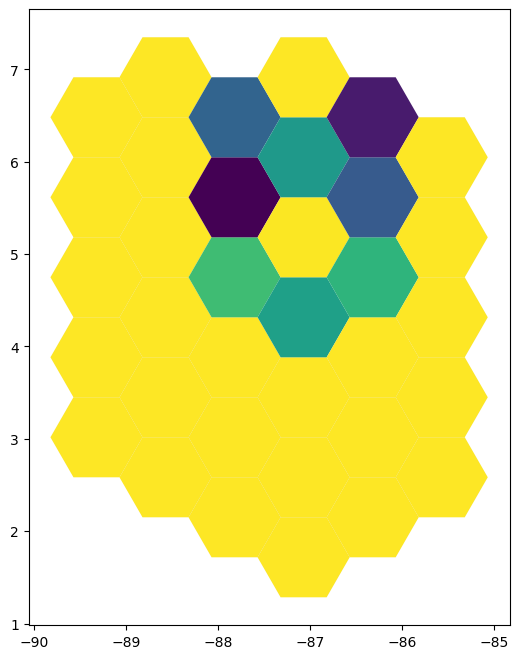

In [16]:
fig, ax = plt.subplots(figsize = (8,8))

ax.set_aspect('equal')
Simpson.plot(ax = ax, column = 'Simpson', cmap = 'viridis', edgecolor = 'grey', linewidth = 0.01)

plt.show()

**OBIS data**

In [1]:
from pyobis import occurrences

In [9]:
#create a polygon to access the OBIS data
min_x, min_y, max_x, max_y = ACMC.total_bounds
geometry = f"POLYGON(({max_x} {min_y}, {min_x} {min_y}, {min_x} {max_y}, {max_x} {max_y}, {max_x} {min_y}))"

In [10]:
query = occurrences.search(geometry=geometry)
query.execute()

Fetching: [████████████████████████████████████████████████████████████████████████████████████████████████████] 4216/4216
Fetched 4216 records.


,rightsHolder,infraphylum,country,date_year,scientificNameID,scientificName,individualCount,dropped,gigaclassid,aphiaID,...,sectionid,subsectionid,minimumElevationInMeters,maximumElevationInMeters,hab,varietyid,variety,parvorder,parvorderid,associatedMedia
0,CAS,Gnathostomata,Costa Rica,1998.0,urn:lsid:marinespecies.org:taxname:293586,Doryrhamphus excisus excisus,1,False,10194.0,293586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SIO,Gnathostomata,NaN,1967.0,urn:lsid:marinespecies.org:taxname:306621,Scopelogadus bispinosus,NaN,False,10194.0,306621,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,KU,Gnathostomata,Costa Rica,1954.0,urn:lsid:marinespecies.org:taxname:125636,Gymnothorax,NaN,False,10194.0,125636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Gnathostomata,NaN,NaN,urn:lsid:marinespecies.org:taxname:105857,Mobula birostris,NaN,False,NaN,1026118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CAS,Gnathostomata,Panama,1956.0,urn:lsid:marinespecies.org:taxname:276587,Polydactylus approximans,2,False,10194.0,276587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4211,NaN,Gnathostomata,Costa Rica,1975.0,urn:lsid:marinespecies.org:taxname:276587,Polydactylus approximans,NaN,False,10194.0,276587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4212,NaN,Gnathostomata,NaN,NaN,urn:lsid:marinespecies.org:taxname:127401,Diodon eydouxii,NaN,False,10194.0,127401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4213,LACM,Gnathostomata,Costa Rica,1964.0,urn:lsid:marinespecies.org:taxname:276400,Dactyloscopus lacteus,1,False,10194.0,276400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4214,NaN,Gnathostomata,NaN,1925.0,NaN,Idiacanthus antrostomus,1,False,10194.0,275151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Returns the data
obis = query.data 

In [15]:
# convert OBIS dataframe to geodataframe
obis = gpd.GeoDataFrame(obis, 
                       geometry=gpd.points_from_xy(obis.decimalLongitude, 
                                          obis.decimalLatitude))

In [16]:
import random

fake_abundance = [random.randint(1, 100) for _ in range(len(obis))]
obis['abundance'] = fake_abundance

<AxesSubplot:>

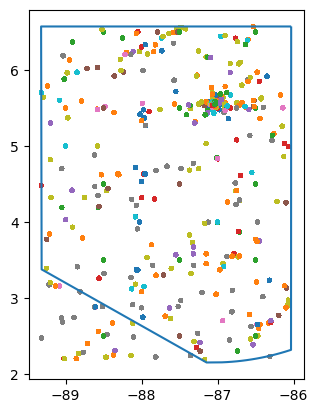

In [17]:
# plot protected area with marine species
# select column name to plot
column_name = 'scientificName'
ax = ACMC.boundary.plot()
obis.plot(ax=ax, markersize=5, column=column_name, 
        antialiased=False, legend_kwds={'bbox_to_anchor': (1, 1)})

In [18]:
#Join in a gdf all the geometries within ACMC
df2 = gpd.clip(obis.set_crs(epsg=4326, allow_override=True), ACMC)

In [19]:
#Spatial join of gdf and grid_gdf
pointInPolys = sjoin(df2, grid, how='inner')

In [23]:
#where num = n(n-1)
pointInPolys['num'] = pointInPolys['abundance']*(pointInPolys['abundance']-1)

In [21]:
#To count the total abundance number from all the species in a grid
N = pd.DataFrame()
N['N'] = pointInPolys.groupby('Grid_ID').apply(lambda x: x['abundance'].sum())

In [26]:
#Merge the datasets based on the Grid_ID
new = pd.merge(pointInPolys, N, on='Grid_ID')

In [34]:
new['simpson'] = 1-((new['num'])/(new['N']*(new['N']-1)))